##  Customer Segmentation with RFM Analysis

###  Project Overview
This project aims to segment customers based on their purchasing behavior using RFM (Recency, Frequency, Monetary) analysis. The goal is to identify valuable customer groups that can help optimize marketing strategies and increase customer retention.

### Business Objective
By understanding different customer segments, businesses can:
- Personalize marketing campaigns
- Improve customer satisfaction
- Allocate resources efficiently
- Identify loyal and high-value customers

We use the UK-based **Online Retail dataset** for our analysis, focusing on customers from 2010 to 2011.


In [52]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import warnings 
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('../data/raw/data.csv', encoding='ISO-8859-1')

#basis overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Step 1: Data Overview

We start by loading and inspecting the dataset to understand the structure and key columns.


In [53]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Step 2: Data Cleaning

We clean the data by:
- Removing rows with missing Customer IDs
- Removing negative or zero quantities and prices

In [54]:
df.shape

(541909, 8)

In [55]:
# Remove rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace = True)

# Remove negative and zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Remove cancelled transactions 
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Convert InvoiceData to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

### Step 3: Exploratory Data Analysis

Let's explore basic purchase patterns: top countries, number of transactions, and average order value.


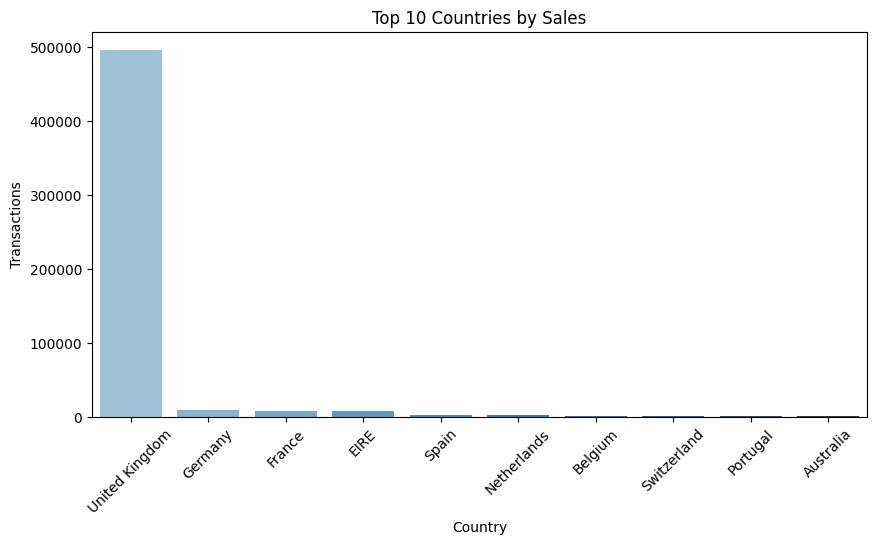

In [43]:
# Top 10 countries by transactions
top_countries = df['Country'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x = top_countries.index, y = top_countries.values, palette = 'Blues_d')
plt.title('Top 10 Countries by Sales')
plt.ylabel('Transactions')
plt.xticks(rotation = 45)
plt.show()

- The **United Kingdom** contributes over 80% of all transactions and revenue.
- Other top contributors include **EIRE**, **Germany**, and **France**, but they form a small fraction.
Business is heavily reliant on the UK — diversification could be explored.


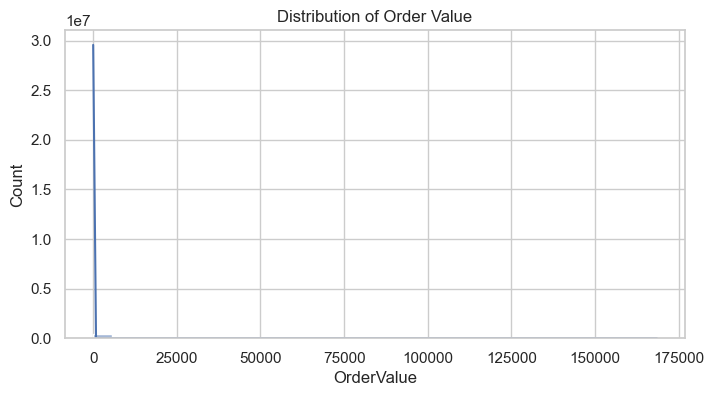

In [57]:
# Distribution of order value
df['OrderValue'] = df['Quantity'] * df['UnitPrice']
plt.figure(figsize=(8,4))
sns.histplot(df['OrderValue'], bins=30, kde=True)
plt.title('Distribution of Order Value')
plt.show()

- Order values are **right-skewed**, with most purchases under £500.
- High-value orders exist but are rare — likely B2B or bulk buyers.<br>
 Loyalty programs could target mid-to-high spenders to increase their frequency.


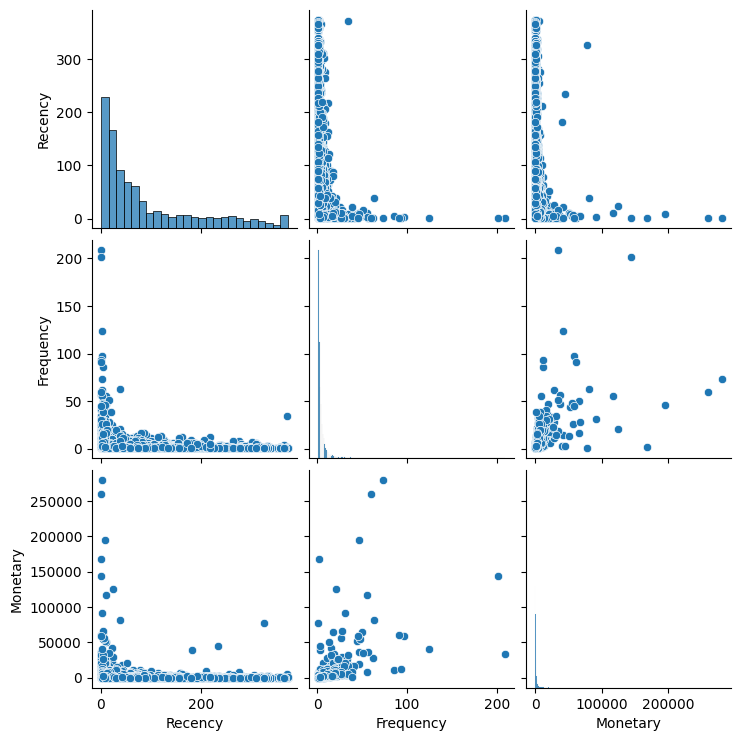

In [12]:
# Bivariate & Multivariate Analysis
sns.pairplot(rfm[['Recency', 'Frequency','Monetary']])

- Recence is right-skewed -- most customers haven't purchased recently.
- Frequency and Monetary show extreme outliers -- some customers buy a lot or spend heavily.

<Axes: >

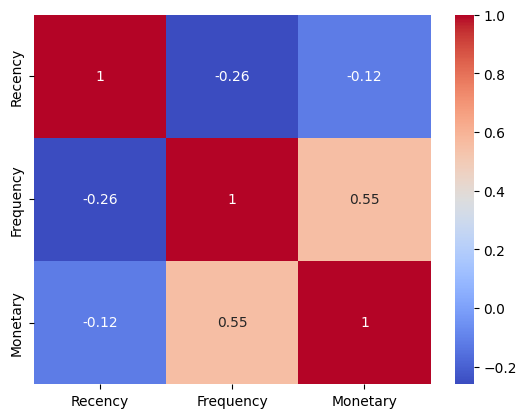

In [13]:
sns.heatmap(rfm[['Recency', 'Frequency','Monetary']].corr(), annot= True, cmap='coolwarm')

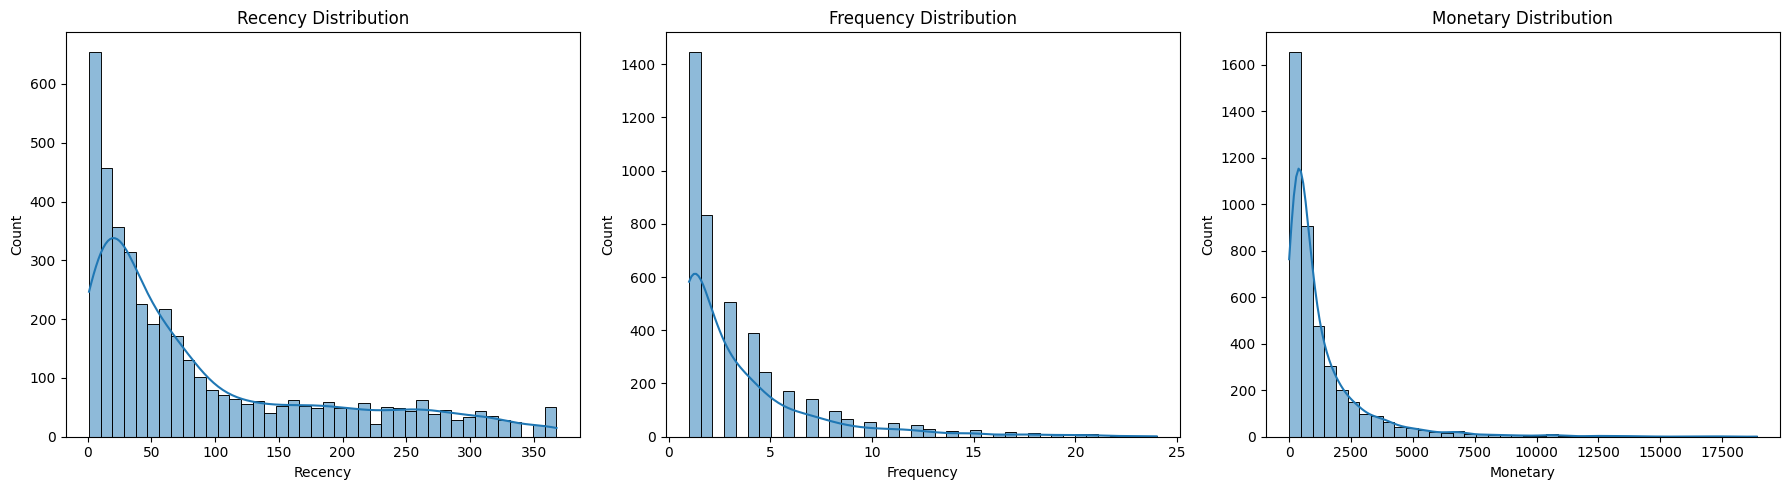

In [42]:
# Univariate Analysis

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm['Recency'] , bins=40, kde = True, ax= axes[0])
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=40, kde= True, ax=axes[1])
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins= 40, kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')

plt.tight_layout()

- Revenue is positively correlated with Quantity, but not linearly.
- Negative correlation between Recency and Frequency -- recent buyers tend to purchase more.

### Step 4: RFM Feature Engineering

RFM stands for:
- **Recency**: Days since the customer's last purchase
- **Frequency**: Total number of purchases
- **Monetary**: Total money spent by the customer

These metrics help us identify:
- Loyal and valuable customers (high F, high M, low R)
- At-risk customers (low F, low M, high R)
- Potential high-spenders (low R, medium F and M)

We calculate RFM values using the snapshot date: **December 10, 2011**


In [58]:
# Set snapshot date
import datetime as dt
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create RFM features
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x:(snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'OrderValue': lambda x: np.sum(x)
}).rename(columns ={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'OrderValue': 'Monetary'
}).reset_index()

In [65]:
rfm.head()


,CustomerID,Recency,Frequency,Monetary
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40
5,12352.0,36,8,2506.04


In [62]:
# Remove extreme outliers
rfm = rfm[rfm['Monetary'] < rfm['Monetary'].quantile(0.99)]
rfm = rfm[rfm['Frequency'] < rfm['Frequency'].quantile(0.99)]
rfm = rfm[rfm['Recency'] < rfm['Recency'].quantile(0.99)]

In [64]:
rfm.to_csv('../data/processed/processed_data.csv', index=False)

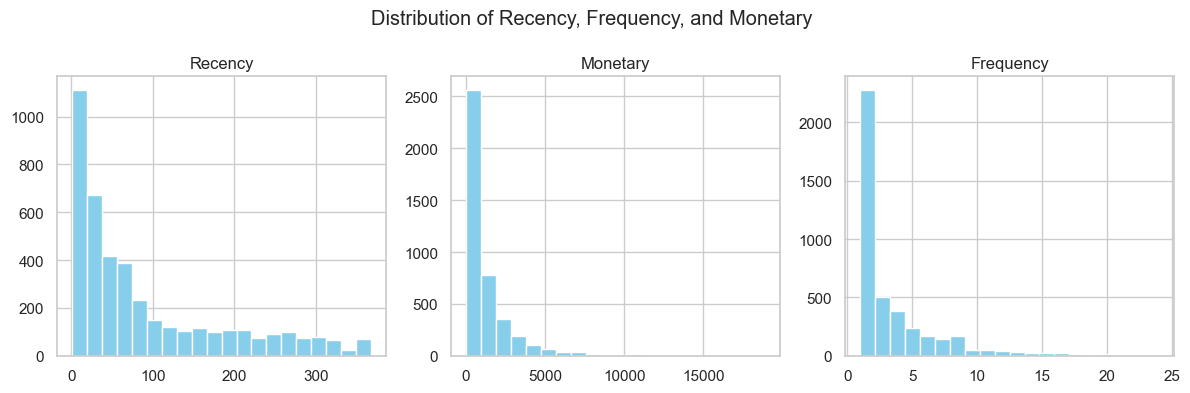

In [46]:
# Visualize RFM distributions 
rfm[['Recency','Monetary','Frequency']].hist(bins = 20, figsize=(12,4), layout = (1, 3), color='skyblue')
plt.suptitle('Distribution of Recency, Frequency, and Monetary')
plt.tight_layout()
plt.show()

In [51]:
rfm[['Recency','Frequency','Monetary']].to_csv('../data/processed/processed_data.csv')

### Step 5: Scoring Customers Based on RFM

We assign scores from 1 to 4 to each RFM value (higher is better) using quantile-based binning.

- **Recency Score**: Lower recency = more recent purchase → higher score
- **Frequency Score**: More orders = more loyal → higher score
- **Monetary Score**: More spending → higher score

We then combine these to create a **segment label** to categorize customers.


In [32]:
# Assign R, F, M Scores using quartiles
r_labels = [4, 3, 2, 1]
f_labels = m_labels = [1, 2, 3, 4]

rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels = r_labels)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=f_labels)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=m_labels)

# Convert to integers
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Combine into one RFM segment and total score
rfm['RFM_Segment'] = rfm['R_Score'].map(str) + rfm['F_Score'].map(str) + rfm['M_Score'].map(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

In [48]:
# Exporting dataframe to csv file
rfm.to_csv('../data/processed/processed_data.csv')

### Step 6: Customer Profiling Based on RFM Score

Based on the total RFM score (3 to 12), we group customers into meaningful segments:
- **Champions**: RFM Score 10–12
- **Loyal Customers**: 8–9
- **Potential Loyalists**: 6–7
- **Needs Attention**: 4–5
- **At Risk**: 1–3


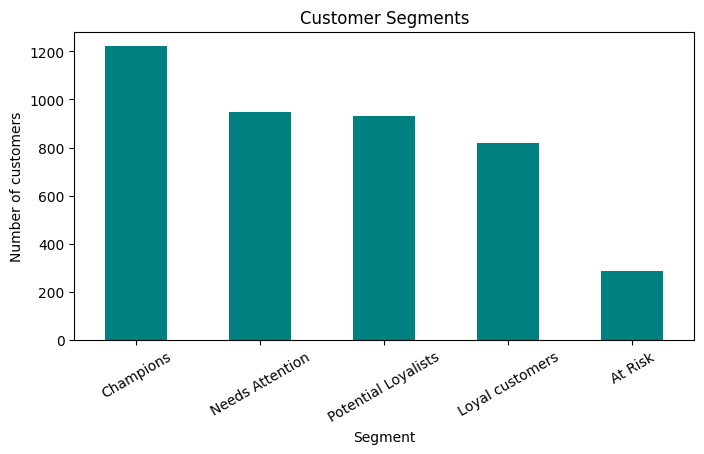

In [33]:
def segment_customer(score):
    if score >= 10:
        return 'Champions'
    elif score >= 8:
        return 'Loyal customers'
    elif score >= 6:
        return 'Potential Loyalists'
    elif score >= 4:
        return 'Needs Attention'
    else: 
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# Display counts of each segment
segment_counts = rfm['Segment'].value_counts()
segment_counts.plot(kind ='bar', color='teal', figsize=(8,4), title='Customer Segments')
plt.ylabel('Number of customers')
plt.xticks(rotation = 30)
plt.show()

In [35]:
# Summary stats per segement
summary = rfm.groupby('Segment').agg({
    'Recency':'mean',
    'Frequency': 'mean',
    'Monetary':'mean'
}).round(1)

summary.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean']
summary = summary.sort_values(by='MonetaryMean', ascending= False)
summary

,RecencyMean,FrequencyMean,MonetaryMean
Segment,,,
Champions,21.3,7.7,3084.2
Loyal customers,52.4,3.2,1127.9
Potential Loyalists,86.5,1.8,607.9
Needs Attention,167.3,1.2,313.9
At Risk,260.9,1.0,166.4


### Segment Insights Summary

This summary table shows the average recency, frequency, and monetary values by segment. Use this to:
- Identify your top segments
- Build strategies like loyalty programs or reactivation offers


In [36]:
# Summary Statistics per segment
segment_summary = rfm.groupby('Segment').agg({
    'Recency':['mean','median'],
    'Frequency':['mean','median'],
    'Monetary': ['mean','median','count']
}).round(1)

# Rename columns for better clarity
segment_summary.columns = ['Recency_Mean', 'Recency_Median','Frequency_Mean','Frequency_Median','Monetary_Mean','Monetary_Median','Customer_Count']

In [37]:
segment_summary = segment_summary.sort_values(by='Monetary_Mean', ascending=False)
segment_summary

,Recency_Mean,Recency_Median,Frequency_Mean,Frequency_Median,Monetary_Mean,Monetary_Median,Customer_Count
Segment,,,,,,,
Champions,21.3,15.0,7.7,6.0,3084.2,2299.0,1221
Loyal customers,52.4,37.0,3.2,3.0,1127.9,890.1,818
Potential Loyalists,86.5,63.0,1.8,2.0,607.9,485.5,932
Needs Attention,167.3,159.0,1.2,1.0,313.9,286.3,948
At Risk,260.9,265.0,1.0,1.0,166.4,158.5,284


### Segment Profiling Summary

- **High Value**: These customers purchase frequently, spend a lot, and bought very recently. They are the business's most loyal and profitable customers — ideal for exclusive loyalty programs or upselling.
  
- **Frequent Buyer**: High purchase frequency but maybe not high spenders. They are brand-loyal and great for promoting subscriptions or bundles.
  
- **Big Spender**: Spend a lot per transaction but may not purchase often. They can be targeted with premium product recommendations or occasional luxury sales.
  
- **New Customer**: Recently acquired, but we don't know their frequency or monetary value yet. Nurture them with welcome campaigns or first-time offers.
  
- **Low Value**: Infrequent, low-spending, and not recent buyers. They are at risk of churn or are one-time customers. Test reactivation or win-back campaigns.
  
- **Average**: These customers show average behavior. Keep them engaged and explore how to push them toward more profitable segments.


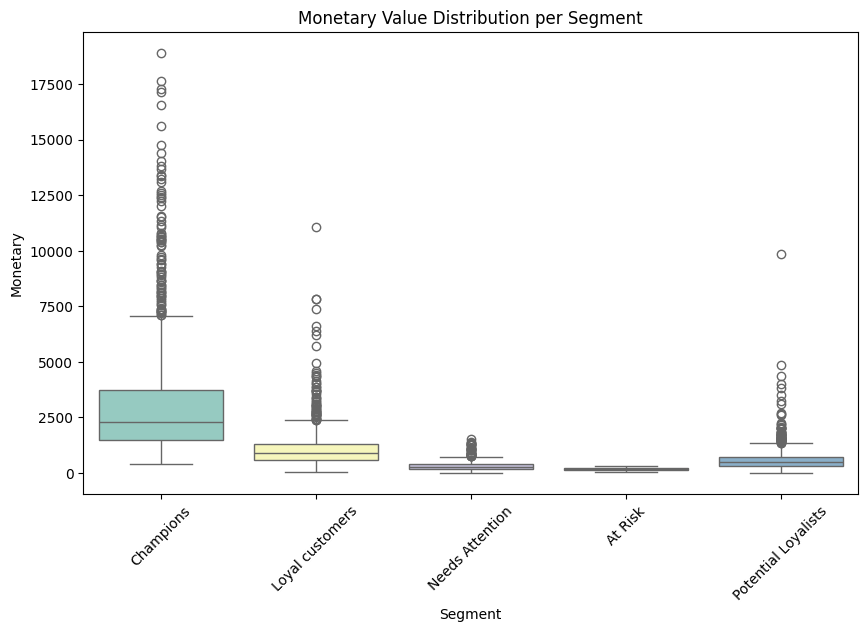

In [38]:
# Boxplot for Monetary by segment
plt.figure(figsize=(10,6))
sns.boxplot(x='Segment', y='Monetary', data =rfm, palette='Set3')
plt.title('Monetary Value Distribution per Segment')
plt.xticks(rotation = 45)
plt.show()

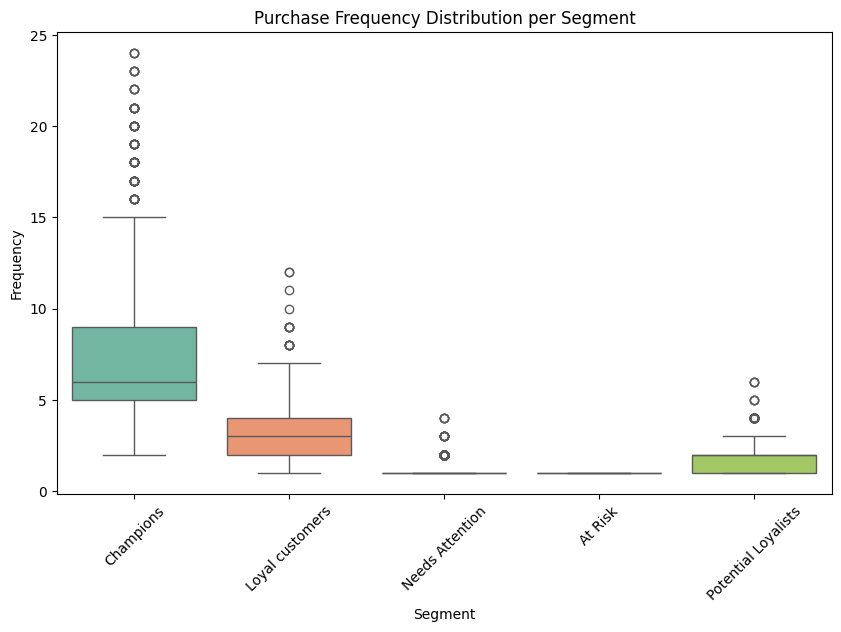

In [39]:
# Boxplot for Frequency by Segment
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='Frequency', data =rfm, palette='Set2')
plt.title('Purchase Frequency Distribution per Segment')
plt.xticks(rotation = 45)
plt.show()

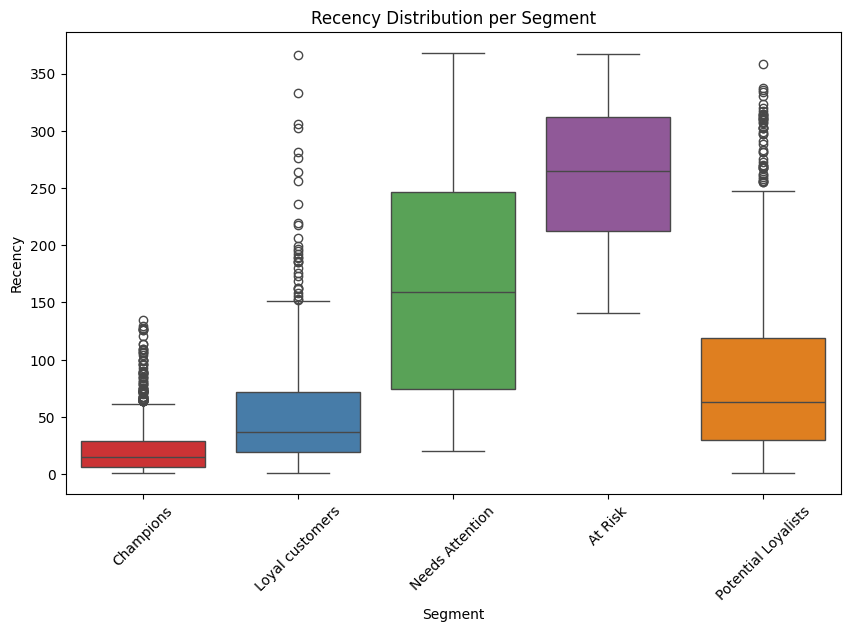

In [40]:
# boxplot for Recency by Segment 
plt.figure(figsize=(10,6))
sns.boxplot(x='Segment', y='Recency', data=rfm, palette='Set1')
plt.title('Recency Distribution per Segment')
plt.xticks(rotation = 45)
plt.show()

### Step 7: Visual Storytelling & Business Insights

Our analysis reveals that the business is strongly dependent on the UK, with a highly skewed order value distribution indicating a mix of retail and bulk buyers. Most customers are recent but low-frequency purchasers, presenting an opportunity for nurturing strategies. 

Identifying and targeting mid-to-high spenders, optimizing inventory based on top-selling SKUs, and leveraging seasonal peaks (e.g., Q4) could drive growth. This business context will inform our next step — customer segmentation using RFM features.


### Summary and Business Takeaways from Exploratory Data Analysis

Our in-depth exploratory data analysis of the UK-based Online Retail dataset has revealed several valuable insights into customer behavior, sales patterns, and market concentration. These findings lay the groundwork for effective customer segmentation and data-driven business strategies.


###  Business Takeaways

1. **Targeted Retention Campaigns**  
   Focus on converting recent but low-frequency buyers into loyal customers through personalized offers and loyalty programs.

2. **Nurture High-Value Customers**  
   Identify and prioritize high spenders for VIP treatment and upselling opportunities.

3. **Inventory Optimization**  
   Stock top-performing SKUs strategically, especially around peak seasons like Q4.

4. **Diversify Customer Base**  
   Reduce dependence on the UK market by exploring acquisition strategies in other high-potential countries.

5. **Data-Driven Segmentation**  
   These insights strongly support the use of RFM segmentation to classify customers for tailored marketing strategies.

---


